In [1]:
from PIL import Image
import os, glob, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
data_dir = "fire_dataset"
categories = ["fire", "non_fire"]
num_classes = len(categories)

In [3]:
# 이미지의 크기
image_w = 128
image_h = 128

In [4]:
# 펼치기 
pixels = image_h * image_w * 3

In [5]:
X = []
y = []

In [6]:
for idx, category in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(num_classes)]
    label[idx] = 1
 
    image_dir = data_dir + "/" + category
    files = glob.glob(image_dir+"/*.png")
    print(category, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
 
        X.append(data)
        y.append(label)
 
        if i % 700 == 0:
            print(category, " : ", f)

fire  파일 길이 :  1431
fire  :  fire_dataset/fire\fire.1.png
fire  :  fire_dataset/fire\fire.308.png
fire  :  fire_dataset/fire\fire.963.png
non_fire  파일 길이 :  869
non_fire  :  fire_dataset/non_fire\non_fire.1.png
non_fire  :  fire_dataset/non_fire\non_fire.822.png


In [7]:
X = np.array(X)
y = np.array(y)
#1 0  이면 man
#0 1  이면 woman 이런식

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("npy/fire_data.npy", xy)
print("ok", len(y))

ok 2300


C:\Users\jangj\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [9]:
X_train, X_test, y_train, y_test = np.load('npy/fire_data.npy', allow_pickle = True) 

In [10]:
categories = ["fire", "non_fire"]
num_classes = len(categories)

#일반화
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
model = Sequential()
model.add(Conv2D(64, 3, strides= 1, padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(64, 3, strides= 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2,2), strides=2))

model.add(Conv2D(128, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(512, 3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D((2, 2), strides=2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0

In [13]:
mcp = ModelCheckpoint('save/best-fire-model.h5',save_best_only=True)

In [14]:
mes = EarlyStopping(patience=50)

In [15]:
rlr = ReduceLROnPlateau(factor=0.1, patience=5)

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0005),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [17]:
history = model.fit(X_train, y_train, 
                    batch_size = 64, 
                    epochs = 500, 
                    verbose = 1,
                    validation_data=(X_test, y_test),
                    callbacks = [mcp, mes, rlr])

Epoch 1/500
27/27 [==============================] - 16s 306ms/step - loss: 5.0902 - accuracy: 0.6029 - val_loss: 0.6987 - val_accuracy: 0.3861 - lr: 5.0000e-04
Epoch 2/500
27/27 [==============================] - 5s 173ms/step - loss: 0.6959 - accuracy: 0.6186 - val_loss: 0.7740 - val_accuracy: 0.3861 - lr: 5.0000e-04
Epoch 3/500
27/27 [==============================] - 5s 188ms/step - loss: 0.6657 - accuracy: 0.6435 - val_loss: 0.7259 - val_accuracy: 0.3861 - lr: 5.0000e-04
Epoch 4/500
27/27 [==============================] - 5s 176ms/step - loss: 0.6020 - accuracy: 0.6754 - val_loss: 1.0184 - val_accuracy: 0.3861 - lr: 5.0000e-04
Epoch 5/500
27/27 [==============================] - 5s 199ms/step - loss: 0.6439 - accuracy: 0.7142 - val_loss: 0.6669 - val_accuracy: 0.6139 - lr: 5.0000e-04
Epoch 6/500
27/27 [==============================] - 5s 170ms/step - loss: 0.5282 - accuracy: 0.7762 - val_loss: 0.7056 - val_accuracy: 0.6313 - lr: 5.0000e-04
Epoch 7/500
27/27 [====================

Epoch 52/500
27/27 [==============================] - 4s 165ms/step - loss: 0.0892 - accuracy: 0.9635 - val_loss: 0.2546 - val_accuracy: 0.9113 - lr: 5.0000e-07
Epoch 53/500
27/27 [==============================] - 4s 159ms/step - loss: 0.0841 - accuracy: 0.9646 - val_loss: 0.2543 - val_accuracy: 0.9113 - lr: 5.0000e-08
Epoch 54/500
27/27 [==============================] - 5s 169ms/step - loss: 0.0975 - accuracy: 0.9623 - val_loss: 0.2544 - val_accuracy: 0.9113 - lr: 5.0000e-08
Epoch 55/500
27/27 [==============================] - 5s 174ms/step - loss: 0.0913 - accuracy: 0.9600 - val_loss: 0.2547 - val_accuracy: 0.9130 - lr: 5.0000e-08
Epoch 56/500
27/27 [==============================] - 5s 172ms/step - loss: 0.0919 - accuracy: 0.9588 - val_loss: 0.2548 - val_accuracy: 0.9130 - lr: 5.0000e-08
Epoch 57/500
27/27 [==============================] - 5s 185ms/step - loss: 0.0994 - accuracy: 0.9571 - val_loss: 0.2544 - val_accuracy: 0.9130 - lr: 5.0000e-08
Epoch 58/500
27/27 [==============

In [18]:
model.save_weights('save/model-fire-weights.h5')

In [19]:
model.save('save/model-fire-whole.h5')

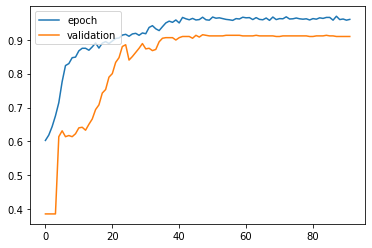

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['epoch', 'validation'], loc = 'upper left')
plt.show()

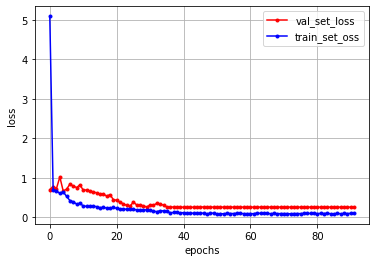

In [21]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [22]:
# predict 메서드로 테스트 세트에 대한 예측 결과 확인

CLASSES = np.array(["fire", "non_fire"])

preds = model.predict(X_test) 
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

In [23]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 24ms/step - loss: 0.2538 - accuracy: 0.9096


[0.2538204491138458, 0.9095652103424072]

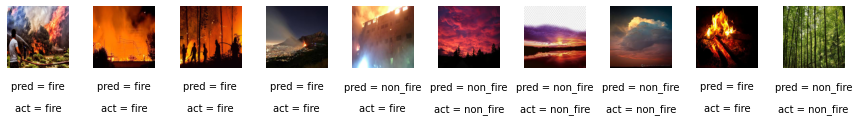

In [24]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i, idx in enumerate(indices):
    img = X_test[idx] 
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
    ax.imshow(img)